In [1]:
from src.helper import *


class AdaptVQEData:
    def __init__(self, initial_energy, pool, sparse_pool, ref_determinant, backend, shots, prev_data = None):
        self.pool = pool
        self.sparse_pool = sparse_pool
        self.shots = shots
        self.backend = backend

        if prev_data is not None:
            self.initial_energy = initial_energy
            self.evolution = copy.deepcopy(prev_data.evolution)

            if not prev_data.result:
                raise ValueError("Previous data does not supply final results")
            
            self.current = copy.deepcopy(prev_data.result)
            self.iteration_count = prev_data.iteration_count

            if prev_data is not None:
                assert(len(self.sparse_pool) == len(prev_data.sparse_pool))

        else:
            self.initial_energy = initial_energy
            self.evolution = {}
            self.evolution["energies"] = []
            self.evolution["total norm"] = []
            self.evolution["selected_grad"] = []
            self.evolution["coefficients"] = []
            self.evolution["energy change"] = []
            self.evolution["indices"] = []

            self.current = {}
            self.current["ansatz"] = []
            self.current["coefficients"] = []
            self.current["indices"] = []
            self.current["ansatz performances"] = []
            self.current["performances"] = []
            self.current["energy"] = None
            self.current["state"] = None
            self.current["total norm"] = None

            self.iteration_count = 0
        
        self.closed = False
        self.success = False

        self.result = {}
            

    def processIteration(self, operator_idx, operator, energy, total_norm, selected_grad, coefficients):
        
        self.current["coefficients"] = copy.deepcopy(coefficients)
        
        if self.iteration_count == 0:
            prev_energy = self.initial_energy
        else:
            prev_energy = self.current['energy']

        energy_change = energy - prev_energy
        print("Energy Change:", energy_change)
        performance = np.abs(energy_change/selected_grad)

        self.current['ansatz performances'].append(performance)
        self.current['performances'].append(performance)

        ansatz_performance = np.average(self.current['ansatz performances'])
        print("Ansatz Performance:", ansatz_performance)
        
        self.current['ansatz'].append(operator)
        self.current['energy'] = energy
        self.current['indices'].append(operator_idx)
        self.current['total norm'] = total_norm

        coefficients_copy = copy.deepcopy(self.current['coefficients'])
        indices_copy = copy.deepcopy(self.current['indices'])

        self.evolution['energies'].append(energy)
        self.evolution['energy change'].append(energy_change)
        self.evolution['total norm'].append(total_norm)
        self.evolution['selected_grad'].append(selected_grad)
        self.evolution['indices'].append(indices_copy)
        self.evolution['coefficients'].append(coefficients_copy)
        self.iteration_count += 1
        

    def close(self, success):
        print("CLOSE")
        print("self.current:", self.current)
        self.result = self.current
        self.closed = True
        self.success = success

    def plot(self, plotGradient = True, detailedTitle = True):
        iteration_number = self.iteration_count
        iteration_labels = [ iterationLable for iterationLable in range(0, self.iteration_count+1)]

        gradient_norms = self.evolution['total norm']
        energies = [self.initial_energy] + self.evolution['energies']


        fig, ax1 = plt.subplots(figsize=[8,8])
        ax1.plot(iteration_labels, energies, '--o', color='navy')
        
        # exact_energy = self.molecule.fci_energy
        exact_energy = -1.13728
        min_accuracy = exact_energy - chemicalAccuracy
        max_accuracy = exact_energy + chemicalAccuracy
        l = ax1.axhspan(min_accuracy, max_accuracy, alpha=0.3, color='cornflowerblue')

        ax1.set_xlabel("Iteration Number")
        ax1.set_ylabel("Energy (au)", color='navy')

        plt.xticks(range(1, 1+ self.iteration_count))

        if plotGradient:
            color2 = 'r'
            ax2 = ax1.twinx()
            ax2.plot(iteration_labels[1:], gradient_norms, '--o', color='maroon')
            ax2.tick_params(axis='y', labelcolor='maroon')
            ax2.set_ylabel("Total Gradient Norm", color='maroon')

        
        


class AdaptVQE:
    def __init__(self, pool, molecule, backend, shots = 1024, max_iter = 50, verbose = False, threshold = 0.1, ref_determinant = None):

        # Init . . .
        self.pool = pool.copy()
        self.molecule = molecule
        self.backend = backend
        self.shots = shots
        self.max_iter = max_iter
        self.verbose = verbose
        self.threshold = threshold
        self.ref_determinant = ref_determinant

        # Hamiltonian and Refernce Value
        self.sparse_hamiltonian = get_sparse_operator(self.molecule.get_molecular_hamiltonian(), self.molecule.get_molecular_hamiltonian().n_qubits)
        self.qubit_hamiltonian = jordan_wigner(self.molecule.get_molecular_hamiltonian())
        dict_hamiltonian = convertHamiltonian(self.qubit_hamiltonian)
        self.hamiltonian = SparsePauliOp.from_list(list(dict_hamiltonian.items()))
        self.ref_value = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=self.hamiltonian).eigenvalue.real
        print(f"Reference value: {self.ref_value:.5f}")

        # Lists
        self.sparse_pool = []
        self.ansatz = []
        self.coefficients = []
        self.indices = []


    def prepare(self, sparse_pool = None, prev_data = None):

        # Sparse Pool
        if sparse_pool is None:
            print("Sparse poll was not provided. Obtaining it . . .")
            for operator in self.pool:
                self.sparse_pool.append(get_sparse_operator(operator, self.molecule.get_molecular_hamiltonian().n_qubits))
        else:
            self.sparse_pool = sparse_pool
        # print(self.sparse_pool)

        # Reference State
        if self.ref_determinant is None:
            self.ref_determinant = getHartreeFockKet(self.molecule.n_electrons, self.molecule.get_molecular_hamiltonian().n_qubits)
        self.reference_state = fromKettoVector(self.ref_determinant)
        self.sparse_reference_state = scipy.sparse.csc_matrix(self.reference_state, dtype=complex).transpose()
        print("sparse reference state", self.sparse_reference_state)

        # Initial Energy
        initial_energy = self.calculateEnergy([],[])

        # Initialize Data
        self.data = AdaptVQEData(initial_energy, self.pool, self.sparse_pool, self.ref_determinant, self.backend, self.shots, prev_data)
        
        print(self.data.current['state'])
        print("sparse reference state >>", self.sparse_reference_state)

        if self.data.current['state'] is None:
            print("None, reference state: ", self.sparse_reference_state)
            self.data.current['state'] = self.sparse_reference_state
            
        print("==Current State 2:", self.data.current['state'])

        print("ADAPT-VQE Configurations:")
        self.printSettings()
    
    def printSettings(self):
        print("> Convergence threshold (gradient norm): ", self.threshold)
        print("> Maximum number of iterations: ", self.max_iter)
        print("> Backend: ",self.backend)      
  

    def computeState(self):
        # print("Compute State")
        state = self.sparse_reference_state
        for (i, operator_idx) in enumerate(self.data.current['indices']):
            print(i, operator_idx)
            coeff = self.data.current['coefficients'][i]
            sparse_operator = self.sparse_pool[operator_idx].multiply(coeff)
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            state = exp_operator * state
        return state


    def calculateGradient(self, operator_idx):
        sparse_operator = self.sparse_pool[operator_idx]
        current_state = self.data.current['state']
        
        # print("sparse operator: >>", sparse_operator)
        # print("current state: >>", current_state)

        test_state = sparse_operator * current_state
        bra = current_state.transpose().conj()
        gradient = 2*(np.abs(bra*self.sparse_hamiltonian*test_state)[0,0].real)
        return gradient
    

    def selectOperator(self):
        selected_gradient = 0
        selected_idx = None
        total_norm = 0

        print("\nNon-zero Gradients (calculated, tolerance E-5)")

        for operator_idx in range(len(self.pool)):
            gradient = self.calculateGradient(operator_idx)
            total_norm += gradient**2

            if gradient > 10**-5:
                print("Operator {}: {}".format(operator_idx, gradient))

            if gradient > selected_gradient:
                selected_idx = operator_idx
                selected_gradient =  gradient

        total_norm = np.sqrt(total_norm)
        print("Total gradient norm: {}".format(total_norm))
        
        return selected_idx, selected_gradient, total_norm
    

    def calculateEnergy(self, coefficients, indices):
        ket = self.sparse_reference_state
        for (coeff, operator_idx) in zip(coefficients, indices):
            sparse_operator = coeff * self.sparse_pool[operator_idx]
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            ket = exp_operator * ket
        bra = ket.transpose().conj()
        energy = ( bra * self.sparse_hamiltonian * ket )[0,0].real
        return energy
        

    def callback(self, nfev, parameters, energy, stddev):
        self.opt_evolution['nfev'].append(nfev)
        self.opt_evolution['parameters'].append(parameters.copy())
        self.opt_evolution['energy'].append(energy)
        self.opt_evolution['stddev'].append(stddev)

    def optimizeCircuit(self, initial_coeff, indices):
        self.opt_evolution = {
            'nfev':[],
            'parameters':[],
            'energy':[],
            'stddev':[]
        }
        parameters = ParameterVector("Params", len(indices))
        ansatz = QuantumCircuit(self.molecule.get_molecular_hamiltonian().n_qubits)

        for i, state in enumerate(self.ref_determinant):
            if state == 1:
                ansatz.x(self.molecule.get_molecular_hamiltonian().n_qubits - 1 -i)

        for i, op in enumerate(indices):
            pauliToCircuit(self.pool[op], parameters[i], ansatz, self.molecule.get_molecular_hamiltonian().n_qubits)
        
        vqe = VQE(
            estimator=Estimator(),
            ansatz=ansatz,
            optimizer=COBYLA(rhobeg=0.1),
            callback = self.callback,
            initial_point=initial_coeff 
            )
        result = vqe.compute_minimum_eigenvalue(operator=self.hamiltonian)

        return result

    def run(self):

        while self.data.iteration_count < self.max_iter:
            print("==================SELF.DATA.RESULT: ", self.data.result)
            print("\n*** Adapt Iteration {} ***\n".format(self.data.iteration_count + 1))
            
            max_idx, max_grad, total_norm = self.selectOperator()
            max_operator = self.pool[max_idx]

            if total_norm < self.threshold:
                print("Convergence condition achieved")
                self.data.close(success = True)
            
                if self.data.result['energy'] is None:
                    print("The chosen threshold was too large")
                    return
                
                print("Final Energy:", self.data.result['energy'])
                error = self.data.result['energy'] - self.molecule.fci_energy
                print("Error", error)
                return 
            
            print("Selected: {}, index {}".format(self.pool[max_idx], max_idx))
            print("(gradient: {})".format(max_grad))

            # new_indices = self.data.current['indices'].copy()
            # new_indices.append(max_idx)

            new_coeffs = copy.deepcopy(self.data.current['coefficients'])
            new_coeffs.append(0)

            min_energy = 0

            performances = []

            for (index, gradient) in zip(max_idx, max_grad):
                operator = self.pool[index]
                new_indices = self.data.current['indices'].copy()
                new_indices.append(index)
                
                print("Optimizing energy with indices {} . . .".format(self.data.current['indices']+[index]))

                opt_result = scipy.optimize.minimize(
                    self.optimizeCircuit, 
                    new_coeffs,
                    (self.data.current['indices']+[index]),
                    method=self.optimizer,
                    options={
                        'rhoberg':0.1,
                        'disp':True
                    }
                )

                optimized_coeffs = list(opt_result.x)
                optimized_energy = self.calculateEnergy(optimized_coeffs, self.data.current['indices']+[index])

                if self.data.iteration_count == 0:
                    previous_energy = self.data.initial_energy
                else:
                    previous_energy = self.data.current['energy']
                
                change = optimized_energy - previous_energy
                performance = np.abs(change/gradient)
                performances.append(performance)

                if optimized_energy < min_energy:
                    selected_operator = operator
                    selected_index = index
                    selected_gradient = gradient
                    selected_coeffs = optimized_coeffs
                    min_energy = optimized_energy
                
            self.data.processIteration(
                selected_index,
                selected_operator,
                min_energy,
                total_norm,
                selected_gradient,
                selected_coeffs,
            )

            new_state = self.computeState()
            self.data.current['state'] = new_state

            print("Energy changes associated with indices:", self.data.evolution['energy_change'])
            print('performances associated with the indices:', self.data.current['ansatz_performances'])
            

            print("==================SELF.DATA.RESULT: ", self.data.result)
        self.data.close(success=False)


In [2]:
from src.operator_pool import fermionicPool, qubitPool
from src.molecular_def import h2, liH
from qiskit_aer import QasmSimulator

fermionic_pool = fermionicPool(2)
qubit_pool = qubitPool(fermionic_pool)

adapt_vqe_h2 = AdaptVQE(pool = qubit_pool,
                        molecule = h2,
                        backend = QasmSimulator(),
                        shots = 1024,
                        max_iter = 50,
                        verbose = True,
                        threshold=0.15,
                        ref_determinant = None
                        )

adapt_vqe_h2.prepare()
adapt_vqe_h2.computeState()

Pool size: 4
Pool Size: 20
Reference value: -1.13728
Sparse poll was not provided. Obtaining it . . .
sparse reference state   (12, 0)	(1+0j)
None
sparse reference state >>   (12, 0)	(1+0j)
None, reference state:    (12, 0)	(1+0j)
==Current State 2:   (12, 0)	(1+0j)
ADAPT-VQE Configurations:
> Convergence threshold (gradient norm):  0.15
> Maximum number of iterations:  50
> Backend:  QasmSimulator('qasm_simulator')


<16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in Compressed Sparse Row format>

In [3]:
adapt_vqe_h2.run()
data = adapt_vqe_h2.data

==================SELF.DATA.RESULT:  {}

*** Adapt Iteration 1 ***


Non-zero Gradients (calculated, tolerance E-5)
Operator 8: 0.36242092403039405
Operator 9: 0.36242092403039405
Operator 10: 0.36242092403039405
Operator 11: 0.36242092403039405
Operator 12: 0.36242092403039405
Operator 13: 0.36242092403039405
Operator 14: 0.36242092403039405
Operator 15: 0.36242092403039405
Total gradient norm: 1.0250811721031448
Selected: 1j [X0 X1 Y2 X3], index 8
(gradient: 0.36242092403039405)


TypeError: 'int' object is not iterable

In [161]:
data.result

{'ansatz': [1j [X0 X1 Y2 X3]],
 'coefficients': [0.11259531250000002],
 'indices': [8],
 'ansatz performances': [0.056631581539837696],
 'performances': [0.056631581539837696],
 'energy': -1.1372837775073963,
 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 'total norm': 1.0250811721031448}

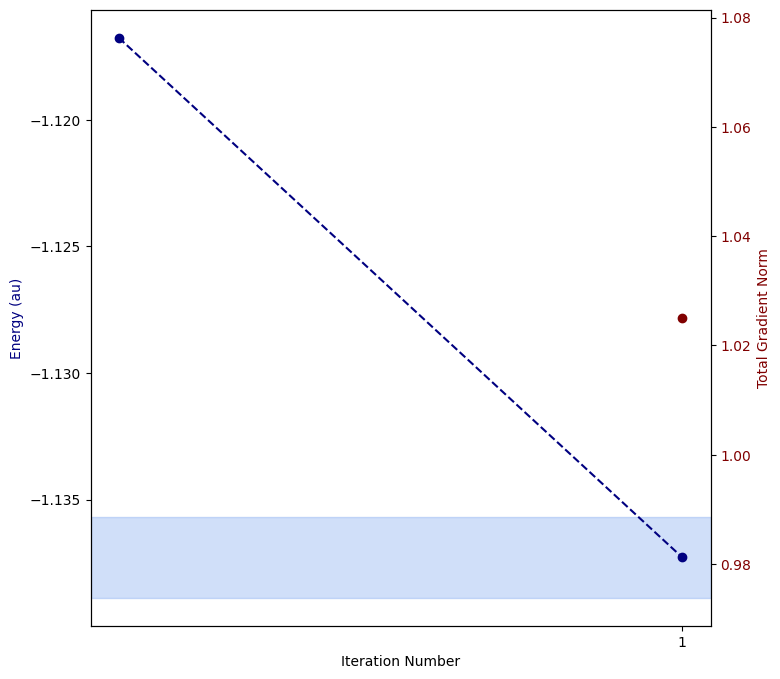

In [162]:
data.plot()

In [163]:
evolution = adapt_vqe_h2.opt_evolution
evolution

{'nfev': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'parameters': [[0.0],
  [0.1],
  [0.2],
  [0.15000000000000002],
  [0.07500000000000001],
  [0.11250000000000002],
  [0.12500000000000003],
  [0.11875000000000002],
  [0.10937500000000001],
  [0.11406250000000001],
  [0.11171875000000002],
  [0.11289062500000002],
  [0.11328125000000003],
  [0.11269531250000002],
  [0.11259531250000002]],
 'energy': [-1.1167593073964248,
  -1.1370190698544886,
  -1.1249887419896099,
  -1.135040389547473,
  -1.1349717072576209,
  -1.1372837048624878,
  -1.1370419830414509,
  -1.1372261365306413,
  -1.1372650160108253,
  -1.1372811809679761,
  -1.1372819997216022,
  -1.1372838156608824,
  -1.13728343194439,
  -1.1372838220760493,
  -1.1372837775073945],
 'stddev': [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]}

In [164]:
print(data.result)

{'ansatz': [1j [X0 X1 Y2 X3]], 'coefficients': [0.11259531250000002], 'indices': [8], 'ansatz performances': [0.056631581539837696], 'performances': [0.056631581539837696], 'energy': -1.1372837775073963, 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 2 stored elements in Compressed Sparse Column format>, 'total norm': 1.0250811721031448}


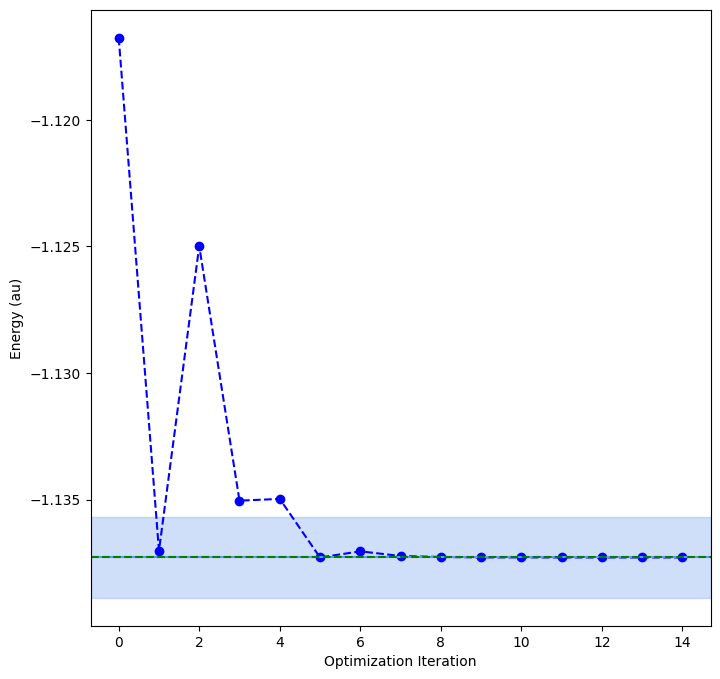

In [165]:
nfev = evolution["nfev"][-1]
energies = []
exact_energy = -1.13728


for i in range(nfev):
  optimized_coefficients = list(evolution["parameters"][i])
  energy = adapt_vqe_h2.calculateEnergy(optimized_coefficients, data.result["indices"])
  energies.append(energy)

fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

color1 = 'b'
ax1.plot(range(nfev), energies, '--o', color = color1)
ax1.set_xlabel("Optimization Iteration")
ax1.set_ylabel("Energy (au)")


minAccuracy = exact_energy - chemicalAccuracy
maxAccuracy = exact_energy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')
plt.axhline(y = exact_energy, color = 'cornflowerblue' , linestyle = '-')
plt.axhline(-1.13728, color='green', linestyle='--')

In [154]:
adapt_vqe_h2.data.result

{'ansatz': [1j [X0 X1 Y2 X3]],
 'coefficients': [0.11259531250000002],
 'indices': [8],
 'ansatz performances': [0.056631581539837696],
 'performances': [0.056631581539837696],
 'energy': -1.1372837775073963,
 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 'total norm': 1.0250811721031448}

In [155]:
print(type(adapt_vqe_h2.data))

<class '__main__.AdaptVQEData'>
